In [1]:
%cd ..

/home/utanko/ondewo/ondewo-t2s


In [2]:
import IPython

In [3]:
IPython.display.Audio("samples/glow_tts_kerstin_mbmelgan/sample_1.wav")

In [4]:
IPython.display.Audio("samples/tacotron2_kerstin_mbmelgan/sample_1.wav")

In [5]:
import librosa
from pysndfx import AudioEffectsChain
import numpy as np
import math
import python_speech_features
import scipy as sp
from scipy import signal

In [6]:
# FROM: https://github.com/dodiku/noise_reduction/blob/master/noise.py

'''------------------------------------
NOISE REDUCTION USING POWER:
    receives an audio matrix,
    returns the matrix after gain reduction on noise
------------------------------------'''
def reduce_noise_power(y, sr):

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = round(np.median(cent))*1.5
    threshold_l = round(np.median(cent))*0.1

    less_noise = AudioEffectsChain().lowshelf(gain=-30.0, frequency=threshold_l, slope=0.8).highshelf(gain=-12.0, frequency=threshold_h, slope=0.5)#.limiter(gain=6.0)
    y_clean = less_noise(y)

    return y_clean


'''------------------------------------
NOISE REDUCTION USING CENTROID ANALYSIS:
    receives an audio matrix,
    returns the matrix after gain reduction on noise
------------------------------------'''

def reduce_noise_centroid_s(y, sr):

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = np.max(cent)
    threshold_l = np.min(cent) + 1e-8 # https://github.com/dodiku/noise_reduction/issues/1

    less_noise = AudioEffectsChain().lowshelf(gain=-12.0, frequency=threshold_l, slope=0.5).highshelf(gain=-12.0, frequency=threshold_h, slope=0.5).limiter(gain=6.0)

    y_cleaned = less_noise(y)

    return y_cleaned

def reduce_noise_centroid_mb(y, sr):

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = np.max(cent)
    threshold_l = np.min(cent) + 1e-8 # https://github.com/dodiku/noise_reduction/issues/1

    less_noise = AudioEffectsChain().lowshelf(gain=-30.0, frequency=threshold_l, slope=0.5).highshelf(gain=-30.0, frequency=threshold_h, slope=0.5).limiter(gain=10.0)
    # less_noise = AudioEffectsChain().lowpass(frequency=threshold_h).highpass(frequency=threshold_l)
    y_cleaned = less_noise(y)


    cent_cleaned = librosa.feature.spectral_centroid(y=y_cleaned, sr=sr)
    columns, rows = cent_cleaned.shape
    boost_h = math.floor(rows/3*2)
    boost_l = math.floor(rows/6)
    boost = math.floor(rows/3)

    # boost_bass = AudioEffectsChain().lowshelf(gain=20.0, frequency=boost, slope=0.8)
    boost_bass = AudioEffectsChain().lowshelf(gain=16.0, frequency=boost_h, slope=0.5)#.lowshelf(gain=-20.0, frequency=boost_l, slope=0.8)
    y_clean_boosted = boost_bass(y_cleaned)

    return y_clean_boosted


'''------------------------------------
NOISE REDUCTION USING MFCC:
    receives an audio matrix,
    returns the matrix after gain reduction on noise
------------------------------------'''
def reduce_noise_mfcc_down(y, sr):

    hop_length = 512

    ## librosa
    # mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
    # librosa.mel_to_hz(mfcc)

    ## mfcc
    mfcc = python_speech_features.base.mfcc(y)
    mfcc = python_speech_features.base.logfbank(y)
    mfcc = python_speech_features.base.lifter(mfcc)

    sum_of_squares = []
    index = -1
    for r in mfcc:
        sum_of_squares.append(0)
        index = index + 1
        for n in r:
            sum_of_squares[index] = sum_of_squares[index] + n**2

    strongest_frame = sum_of_squares.index(max(sum_of_squares))
    hz = python_speech_features.base.mel2hz(mfcc[strongest_frame])

    max_hz = max(hz)
    min_hz = min(hz)

    speech_booster = AudioEffectsChain().highshelf(frequency=min_hz*(-1)*1.2, gain=-12.0, slope=0.6).limiter(gain=8.0)
    y_speach_boosted = speech_booster(y)

    return (y_speach_boosted)

def reduce_noise_mfcc_up(y, sr):

    hop_length = 512

    ## librosa
    # mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
    # librosa.mel_to_hz(mfcc)

    ## mfcc
    mfcc = python_speech_features.base.mfcc(y)
    mfcc = python_speech_features.base.logfbank(y)
    mfcc = python_speech_features.base.lifter(mfcc)

    sum_of_squares = []
    index = -1
    for r in mfcc:
        sum_of_squares.append(0)
        index = index + 1
        for n in r:
            sum_of_squares[index] = sum_of_squares[index] + n**2

    strongest_frame = sum_of_squares.index(max(sum_of_squares))
    hz = python_speech_features.base.mel2hz(mfcc[strongest_frame])

    max_hz = max(hz)
    min_hz = min(hz)

    speech_booster = AudioEffectsChain().lowshelf(frequency=min_hz*(-1), gain=12.0, slope=0.5)#.highshelf(frequency=min_hz*(-1)*1.2, gain=-12.0, slope=0.5)#.limiter(gain=8.0)
    y_speach_boosted = speech_booster(y)

    return (y_speach_boosted)

'''------------------------------------
NOISE REDUCTION USING MEDIAN:
    receives an audio matrix,
    returns the matrix after gain reduction on noise
------------------------------------'''

def reduce_noise_median(y, sr):
    y = sp.signal.medfilt(y,3)
    return (y)


'''------------------------------------
SILENCE TRIMMER:
    receives an audio matrix,
    returns an audio matrix with less silence and the amout of time that was trimmed
------------------------------------'''
def trim_silence(y):
    y_trimmed, index = librosa.effects.trim(y, top_db=20, frame_length=2, hop_length=500)
    trimmed_length = librosa.get_duration(y) - librosa.get_duration(y_trimmed)

    return y_trimmed, trimmed_length


'''------------------------------------
AUDIO ENHANCER:
    receives an audio matrix,
    returns the same matrix after audio manipulation
------------------------------------'''
def enhance(y):
    apply_audio_effects = AudioEffectsChain().lowshelf(gain=10.0, frequency=260, slope=0.1).reverb(reverberance=25, hf_damping=5, room_scale=5, stereo_depth=50, pre_delay=20, wet_gain=0, wet_only=False)#.normalize()
    y_enhanced = apply_audio_effects(y)

    return y_enhanced

'''------------------------------------
OUTPUT GENERATOR:
    receives a destination path, file name, audio matrix, and sample rate,
    generates a wav file based on input
------------------------------------'''
def output_file(destination ,filename, y, sr, ext=""):
    destination = destination + filename.replace("/", "_")[:-4] + ext + '.wav'
    librosa.output.write_wav(destination, y, sr)


'''------------------------------------
LOGIC:
    [1] load file
    [2] reduce noise
    [3] trim silence
    [4] output file
sample files:
    01_counting.m4a
    02_wind_and_cars.m4a
    03_truck.m4a
    04_voices.m4a
    05_ambeint.m4a
    06_office.m4a
------------------------------------'''

'------------------------------------\nLOGIC:\n    [1] load file\n    [2] reduce noise\n    [3] trim silence\n    [4] output file\nsample files:\n    01_counting.m4a\n    02_wind_and_cars.m4a\n    03_truck.m4a\n    04_voices.m4a\n    05_ambeint.m4a\n    06_office.m4a\n------------------------------------'

In [61]:
root_dir = "samples/"
samples = ["glow_tts_kerstin_mbmelgan/sample_3.wav", "glow_tts_florian_mbmelgan/sample_3.wav", "glow_tts_sandra_mbmelgan/sample_3.wav"]
#samples = ["experiments/glow_tts_kerstin_mbmelgan_sample_3_logmmse.wav", "experiments/glow_tts_florian_mbmelgan_sample_3_logmmse.wav", "experiments/glow_tts_sandra_mbmelgan_sample_3_logmmse.wav"]

for filename in samples:
    # reading a file
    y, sr = librosa.load(root_dir + filename, sr=22_050)

    # reducing noise using db power
    y_reduced_power = reduce_noise_power(y, sr)
    y_reduced_centroid_s = reduce_noise_centroid_s(y, sr)
    y_reduced_centroid_mb = reduce_noise_centroid_mb(y, sr)
    y_reduced_mfcc_up = reduce_noise_mfcc_up(y, sr)
    y_reduced_mfcc_down = reduce_noise_mfcc_down(y, sr)
    y_reduced_median = reduce_noise_median(y, sr)

    # trimming silences
    #y_reduced_power, time_trimmed = trim_silence(y_reduced_power)
    # print (time_trimmed)
    #y_reduced_centroid_s, time_trimmed = trim_silence(y_reduced_centroid_s)
    # print (time_trimmed)
    #y_reduced_power, time_trimmed = trim_silence(y_reduced_power)
    # print (time_trimmed)
    #y_reduced_centroid_mb, time_trimmed = trim_silence(y_reduced_centroid_mb)
    # print (time_trimmed)
    #y_reduced_mfcc_up, time_trimmed = trim_silence(y_reduced_mfcc_up)
    # print (time_trimmed)
    #y_reduced_mfcc_down, time_trimmed = trim_silence(y_reduced_mfcc_down)
    # print (time_trimmed)
    #y_reduced_median, time_trimmed = trim_silence(y_reduced_median)

    # generating output file [1]
    output_file("samples/experiments/", filename, y_reduced_power, sr, '_pwr')
    #output_file("samples/experiments/", filename, y_reduced_centroid_s, sr, '_ctr_s')
    #output_file("samples/experiments/", filename, y_reduced_centroid_mb, sr, '_ctr_mb')
    output_file("samples/experiments/", filename, y_reduced_mfcc_up, sr, '_mfcc_up')
    output_file("samples/experiments/", filename, y_reduced_mfcc_down, sr, '_mfcc_down')
    #output_file("samples/experiments/", filename, y_reduced_median, sr, '_median')
    output_file("samples/experiments/", filename, y, sr, '_orig')

In [7]:
#!pip install git+https://github.com/wilsonchingg/logmmse.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/wilsonchingg/logmmse.git to /tmp/pip-req-build-6vhmdseq
  Created wheel for logmmse: filename=logmmse-1.5-py3-none-any.whl size=5030 sha256=da5e7f5d18e7bd5e2ee9e68b97bca64f26df74d865c572c59d071e2a63c00af7
  Stored in directory: /tmp/pip-ephem-wheel-cache-gnku_qj3/wheels/3a/55/a8/feba62fc98a4077ee3fb0abff001dfe660404d367eedc461d4
Successfully built logmmse


In [64]:
# FROM: https://github.com/wilsonchingg/logmmse
import logmmse

root_dir = "samples/"
#samples = ["glow_tts_kerstin_mbmelgan/sample_3.wav", "glow_tts_florian_mbmelgan/sample_3.wav", "glow_tts_sandra_mbmelgan/sample_3.wav"]
samples = ["experiments/glow_tts_kerstin_mbmelgan_sample_3_mfcc_up.wav", "experiments/glow_tts_florian_mbmelgan_sample_3_mfcc_up.wav", "experiments/glow_tts_sandra_mbmelgan_sample_3_mfcc_up.wav"]

for filename in samples:
    y, sr = librosa.load(root_dir + filename, sr=22_050)
    y_reduced = logmmse.logmmse(y, sr, output_file=None, initial_noise=100, window_size=0, noise_threshold=0.15)
    output_file("samples/experiments/", filename, y_reduced, sr, '_logmmse')
    output_file("samples/experiments/", filename, y, sr, '_orig')

In [78]:
# using the pyroomacoustics library
from pyroomacoustics.denoise.spectral_subtraction import apply_spectral_sub
from pyroomacoustics.denoise.subspace import apply_subspace
from pyroomacoustics.denoise.iterative_wiener import apply_iterative_wiener

for filename in samples:
    y, sr = librosa.load(root_dir + filename, sr=22_050)
    
    # there's an error
    #y_spec = apply_spectral_sub(y, nfft=512, db_reduc=25, lookback=12, beta=30, alpha=1)
    
    # takes super long
    #y_sub = apply_subspace(y, frame_len=256, mu=10, lookback=10, skip=2, thresh=0.01)
    
    # quiet results and similar to input, maybe needs some parameter finetuning
    y_wiener = apply_iterative_wiener(y, frame_len=1024, lpc_order=50, iterations=10, alpha=0.5, thresh=0.1)
    
    #output_file("samples/experiments/", filename, y_spec, sr, '_spectr')
    #output_file("samples/experiments/", filename, y_sub, sr, '_sub_denoise')
    output_file("samples/experiments/", filename, y_wiener, sr, '_wiener')
    output_file("samples/experiments/", filename, y, sr, '_orig')

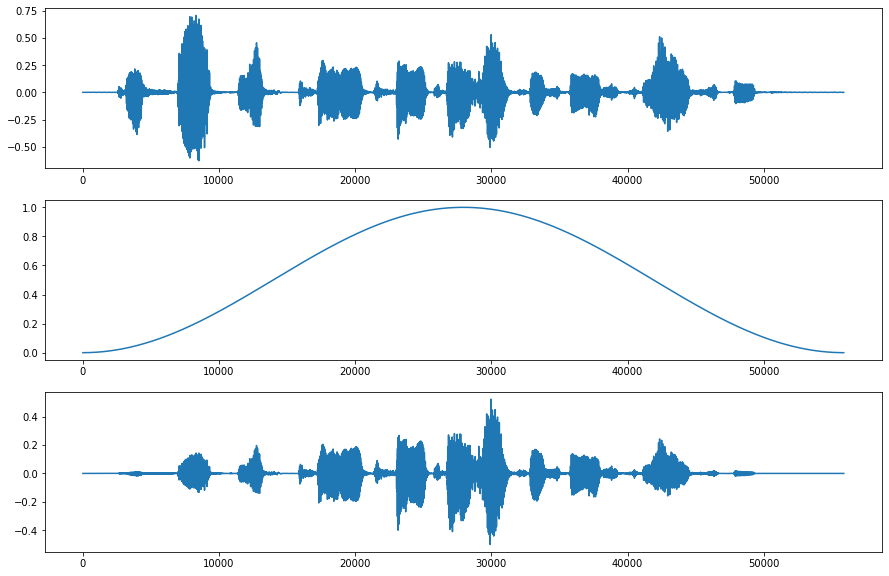

In [27]:
from matplotlib import pyplot as plt
import numpy as np
import scipy

y, sr = librosa.load(root_dir + "glow_tts_kerstin_mbmelgan/sample_9.wav", sr=16_000)
y = y[15000:]

plt.figure(figsize=(15,10))
plt.subplot(3, 1, 1)
plt.plot(y)

han = scipy.signal.tukey(len(y), alpha=1.5)
yy = y * han
plt.subplot(3, 1, 2)
plt.plot(han)
plt.subplot(3, 1, 3)
plt.plot(yy)